## Forms layouts labelling approach based on OCR text, TF-IDF features and DBSCAN clustering algorithm 

This notebook shows an end-to-end example of how to process forms document images and extract layout information based on OCR text features clustering.  
This process can be used to make layout type discovery and annotation much easier and faster - especially for scenarios with big datasets with many, unknown forms layout types.  
The scenario described below can be used as a preparation step for training models with Azure Forms Recognizer service.

### Navigation:
1. [Setup](#1.-Setup)  
    1.1 [Installing requirements](#1.1-Installing-requirements)  
    1.2 [Imports](#1.2-Imports)  
    1.3 [Example dataset preparation](#1.3-Example-dataset-preparation)  
2. [Data processing](#2.-Data-processing)  
    2.1 [PDF to image](#2.1-PDF-to-image)   
    2.2 [Image to OCR text](#2.2-Image-to-OCR-text)  
3. [Text preprocessing](#3.-Text-preprocessing)  
    3.1 [Creating a DataFrame](#3.1-Creating-a-DataFrame)   
    3.2 [Reading OCR from json files](#3.2-Reading-OCR-from-json-files)   
    3.3 [Cleaning/filtering text](#3.3-Cleaning/filtering-text)   
    3.4 [Words vocabulary based filtering with fuzzy matching](#3.4-Words-vocabulary-based-filtering-with-fuzzy-matching) 
4. [Clustering/labelling](#4.-Clustering/labelling)  
    4.1 [Features generation with TFIDF](#4.1-Features-generation-with-TFIDF)  
    4.2 [Clustering with DBSCAN](#4.2-Clustering-with-DBSCAN)  
    4.3 [Plotting and investigating results with IPyPlot package](#4.3-Plotting-and-investigating-results-with-IPyPlot-package)  
    4.4 [Saving results](#4.4-Saving-results)  
5. [Using your own data](#5.-Using-your-own-data)

## 1. Setup
### 1.1 Installing requirements
[back to the top](#Navigation:)

In [ ]:
import sys
! {sys.executable} -m pip install -r ../requirements.txt

### 1.2 Imports
[back to the top](#Navigation:)

In [1]:
# Setting autoreload to automatically pickup changes in local packages imported from `../src` directory 
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
# to make all the modules under `src` directory available for importing:
import sys
sys.path.append("../src")  

In [3]:
# might need to set this to your own directory when working with your data
DATASET_DIR = '../datasets/example_dataset'
DATA_DIR = os.path.join(DATASET_DIR, 'data')

### 1.3 Example dataset preparation
[back to the top](#Navigation:)

In this notebook we are using a fabricated dataset example but based on this example you should be able to easily replace it with your data.

For simplicity and to make our example dataset light we only have 3 invoice-like documents (each representing different form layout type) and to make this dataset bigger we simply clone those documents to have 10 samples (reasonable represenation) per invoice layout type.  

You can find our fabricated dataset under `../datasets/example_dataset` directory.

**We do realize that this is a very fake and simple dataset but it serves the purpose of this example.  
We did run the same code for a dataset of thousands of invoices for hundreds of different providers and layout types and it was proven to be working just excellent.**

If you wish to run this notebook with your own data please refer to the [last section](#5.-Using-your-own-data) of this tutorial

In [ ]:
pdf_files = glob.glob(os.path.join(DATA_DIR, '*.pdf'))

for pdf_file in pdf_files:
    for i in range(1, 10):
        shutil.copyfile(pdf_file, pdf_file.replace('0.pdf', str(i) + '.pdf'))

## 2. Data processing
[back to the top](#Navigation:)

While this part is very important it serves only as code usage example.  
Do note that running either `2.1` or `2.2` on a local machine in a non-distributed way for a larger dataset (e.g. thousands of documents) might take hours or even days to complete.  
For more efficient processing pipeline you can reuse the code below but it should be run in a distributed way with a lot of parallel workers.  

### 2.1 PDF to image
[back to the top](#Navigation:)

We need to extract images from our PDF documents.  
Skip this step in case your data is already in image format such as `.jpg` or `.png`

In [ ]:
from data_processing import pdf_to_images

pdf_files = glob.glob(os.path.join(DATA_DIR, '*.pdf'))

for pdf_file in pdf_files:
    _ = pdf_to_images(pdf_file, save_images=True)

### 2.2 Image to OCR text
[back to the top](#Navigation:)


To extract text from images we need to use some form of OCR solution.  
Code below is using [PyTesseract](https://pypi.org/project/pytesseract) package as an OCR solution to extract text from images.  
Feel free to use other services and software.

In [ ]:
from data_processing import image_to_text

image_files = glob.glob(os.path.join(DATA_DIR, '*.png'))

for image_file in image_files:    
    image_to_text(
        image_file,
        fix_orientation=True,
        save_output=True,
        continue_on_error=True,
        verbose=1)            

## 3. Text preprocessing
[back to the top](#Navigation:)

In this part we will focus on reading raw text from OCR output and applying some cleaning/filtering steps which will serve as preprocessing for our features generation step later on.

### 3.1 Creating a DataFrame
[back to the top](#Navigation:)

We need to start from creating a DataFrame which will be used in all of the steps further ahead.  
This step will result in a pandas.DataFrame object with all the necessary fields.

In [5]:
# build a DataFrame based on specific file extension and directory with the data
from df_helpers import create_dataframe_from_files

df_example = create_dataframe_from_files(
    data_dir=DATA_DIR,
    file_ext='.png',
#     load_ground_truth=os.path.join(DATASET_DIR, 'df_example_pred.csv'),
    dropna=True)
df_example.head(1)

Rows count before removing NaN values:  30
Rows count after removing NaN values:  30


,ImagePath,FileName,PDFPath,OCRJsonPath,LayoutType
ImageName,,,,,
100_0.png,../datasets/example_dataset\data\100_0.png,100_0,../datasets/example_dataset\data\100_0.pdf,../datasets/example_dataset\data\100_0.json,-1


#### Use code below to create a datframe based on an existing DF
```python
from df_helpers import create_dataframe_from_pd

df = pd.read_csv(os.path.join(DATASET_DIR, 'df_example.csv'))
df = create_dataframe_from_pd(
    df, data_dir=DATA_DIR)
df.head(1)
```

### 3.2 Reading OCR from json files
[back to the top](#Navigation:)

In this step we're reading OCR results from `json` file into plain text under `OCRText` column in our DataFrame.  
In case you're using a different OCR solution you should replace this code with something that will load your OCR results under the `OCRText` column in our DataFrame. 

In [6]:
from df_helpers import read_ocr_from_json

# read ocr data from json file for each row
df_example = read_ocr_from_json(
    df_example)
df_example.head(1)

,ImagePath,FileName,PDFPath,OCRJsonPath,LayoutType,OCRText
ImageName,,,,,,
100_0.png,../datasets/example_dataset\data\100_0.png,100_0,../datasets/example_dataset\data\100_0.pdf,../datasets/example_dataset\data\100_0.json,-1,ALESPERSON JOB PAYMEN...


### 3.3 Cleaning/filtering text
[back to the top](#Navigation:)

In [7]:
from df_helpers import clean_text_column

# clean ocr text for each row
df_example = clean_text_column(
    df_example,
    chars_regex="[a-zA-Z]+",
    keep='all',
    min_words_count=10)
df_example.head(1)

Removing empty texts:  0
Total rows count:  30


,ImagePath,FileName,PDFPath,OCRJsonPath,LayoutType,OCRText,TextClean
ImageName,,,,,,,
100_0.png,../datasets/example_dataset\data\100_0.png,100_0,../datasets/example_dataset\data\100_0.pdf,../datasets/example_dataset\data\100_0.json,-1,ALESPERSON JOB PAYMEN...,alesperson job payment terms due date kamil sa...


### 3.4 Words vocabulary based filtering with fuzzy matching
[back to the top](#Navigation:)

Although this step is not necessary to perform clustering it is highly recommended to apply it as it gets rid of all the unnecessary/noisy words and ensures that the final features will focus completely on layout related words only

In [8]:
# We need to start from creating a vocabulary of words used to create the form layout.
# So for invoices we will be looking at field names like: address, invoice, number, quantity, total, etc.
# Below line loads a list of such words for invoices from an already prepared file:
with open("../invoice_vocabulary.txt", 'r') as file:
    invoice_vocabulary = file.read().replace('\n', ' ').split()
print("First five words from vocabulary: ", invoice_vocabulary[:5])

First five words from vocabulary:  ['invoice', 'credit', 'memo', 'ship', 'address']


#### We're using multiprocessing to speed up the process of fuzzy matching filtering function (especially useful when processing bigger number of documents)

In [9]:
from text_features import fuzzy_replace
from multiprocess import Pool
from functools import partial


all_text = df_example['TextClean'].values

max_pool = 10  # careful with this parameter
pool = Pool(max_pool)
pool_outputs = pool.map(
    partial(
        fuzzy_replace,
        query_list = invoice_vocabulary,
        threshold=85,  # word similarity threshold used for fuzzy matching
        whitelist=True),
    all_text
)
pool.close()
pool.join()
pool.terminate()

df_example['TextFiltered'] = pool_outputs
df_example.head(1)

,ImagePath,FileName,PDFPath,OCRJsonPath,LayoutType,OCRText,TextClean,TextFiltered
ImageName,,,,,,,,
100_0.png,../datasets/example_dataset\data\100_0.png,100_0,../datasets/example_dataset\data\100_0.pdf,../datasets/example_dataset\data\100_0.json,-1,ALESPERSON JOB PAYMEN...,alesperson job payment terms due date kamil sa...,payment terms due date sales due quantity...


## 4. Clustering/labelling
[back to the top](#Navigation:)

This part should be interactively iterated through step by step until clustering starts to return satisfying results.  
With each iteration parameter tweaking will be required based on previous results and observation.

### 4.1 Features generation with TFIDF
[back to the top](#Navigation:)

To transform our texts into feature vectors which we can use for clustering, we will use [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) and more precisely `TFIDFProcessor` class which handles everything for us (it's using [TfidfVectorizer class from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html))

**MAX_FEAT** - Maximum number of features (different words or ngrams) to be outputed from TFIDF

**NGRAM_RANGE** - The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.  
Example:  
A string `"invoice number id"` with NGRAM_RANGE set to `(1, 2)` would be turned into a set of such list of strings:  
```
["invoice", "number", "id", "invoice number", "number id"]
```


**PCA_COMP** - Number of components to use in PCA algorithm. This defines the final size of the feature vector.  
In general this should be kept as low as possible and it should be increased with the amount and variety of the data.  
The more diverse and bigger the dataset the higher this value should be to accomodate all the features

In [10]:
from text_features import TFIDFProcessor

#TFIDF
MAX_FEAT = 500
NGRAM_RANGE = (2, 4)

#PCA
PCA_COMP = 5

tfidf_proc = TFIDFProcessor(
    ngram_range=NGRAM_RANGE,
    max_feat=MAX_FEAT,
    use_pca=True,
    pca_components=PCA_COMP,
    use_scaler=False,
    verbose=2,
)

X = df_example["TextFiltered"].values
IMG_PATHS = df_example["ImagePath"].values
X = tfidf_proc.fit_pipeline(X)

TFIDF shape: (30, 115)
PCA shape: (30, 5)


### 4.2 Clustering with DBSCAN
[back to the top](#Navigation:)

We're using DBSCAN which is a density-based clustering algorithm [implemented in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) to extract groups of feature vectors which are in a close neighborhood to each other (simply are similar or the same).  
Important part of this algorithm is that we don't have to determine number of clusters we're looking for up front - it will figure it out for us instead based on the 2 parameters that we will provide:

**EPS** - element-wise distance threshold to determine if elements are close enough to be in the same cluster. The higher the final features size (PCA components number) the higher eps value should be

**MIN_SAMPLES** - min samples in the same "neighborhood" to be considered a cluster. The higher this value will be the more well represented layout types we will pick up.

One important thing to monitor here is the `Estimated number of noise points` (or simply `-1` cluster label) count. These data points are feature vectors which didn't make it into any of the detected clusters nor they were able to form a cluster of their own.

In [11]:
from clustering import fit_dbscan

EPS = 0.3
MIN_SAMPLES = 10

labels, dbscan = fit_dbscan(
    X, eps=EPS, min_samples=MIN_SAMPLES, plot=False, n_jobs=-1)

Estimated number of clusters: 3
Estimated number of noise points: 0


In [ ]:
# this is how to sideload and reuse previously known layout types (if present)
put_mask = df_clean['LayoutType'].values != '-1'
labels[put_mask] = df_clean['LayoutType'].values[put_mask]

In [12]:
# lists detected clusters + value counts for each
for i in np.unique(labels):
    print('Cluster %s count: ' % i, sum(labels == i))

Cluster 00 count:  10
Cluster 01 count:  10
Cluster 02 count:  10


In [ ]:
# use this to change the label for all elements from specific cluster to another label
# e.g. when one of the cluster turns out to be extremely noisy (happens with really big dataset)
# you can push it back to `-1`
labels[labels=='11'] = '-1'

In [ ]:
# use this to change labels for specific elements from a specific cluster
from clustering import change_labels

labels = change_labels(
    labels.copy(), 
    cluster_name='16',
    idx_to_change=[1, 45], 
    target_labels=['-1', '05']
)

### 4.3 Plotting and investigating results with IPyPlot package
[back to the top](#Navigation:)

[IPyPlot](https://github.com/karolzak/ipyplot) is an external python package which significantly improves and speeds up displaying images in notebooks

After installing you need to import it as below and simply start using:

In [14]:
import ipyplot

#### Print top N samples for each cluster in a separate interactive tab


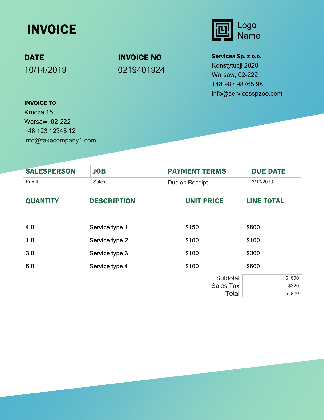
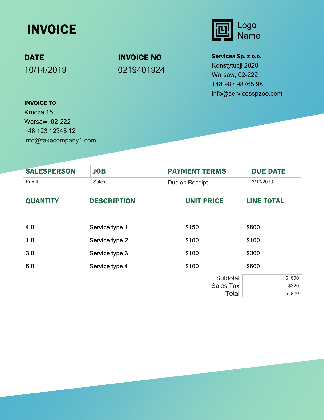
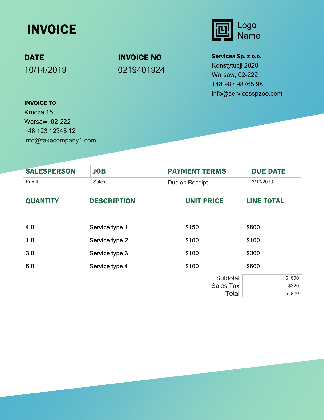
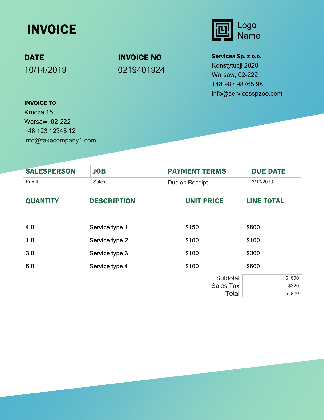
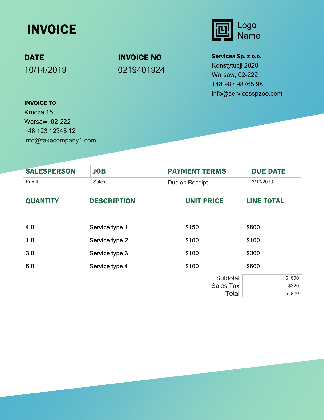
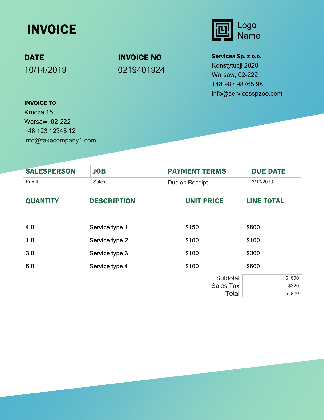
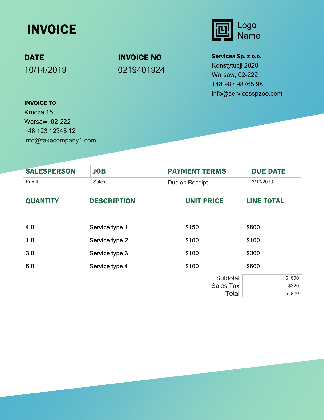
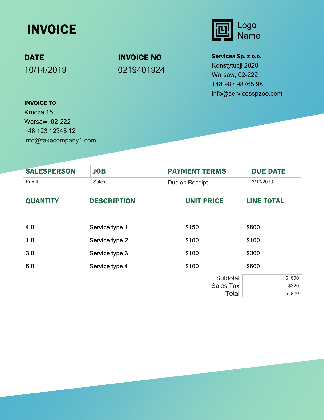
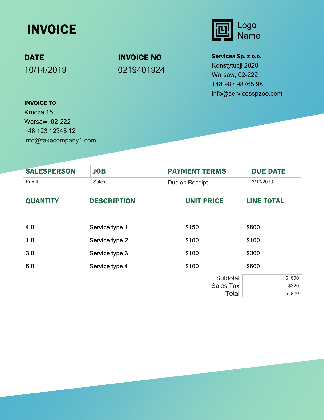
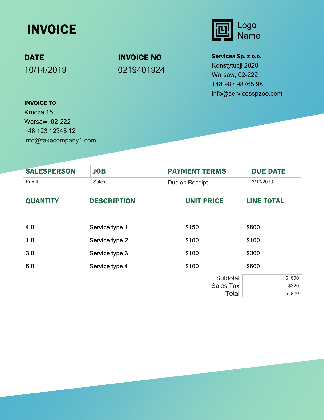
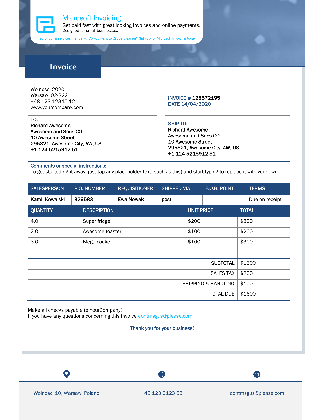
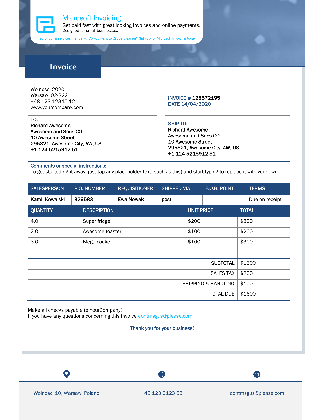
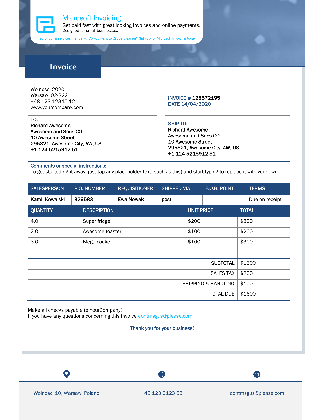
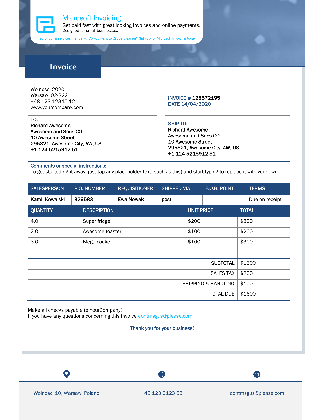
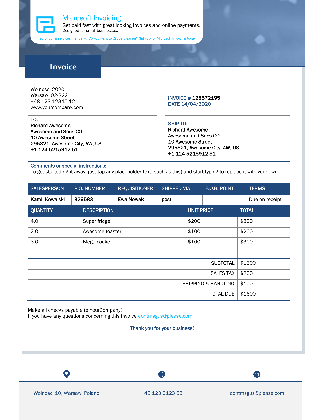
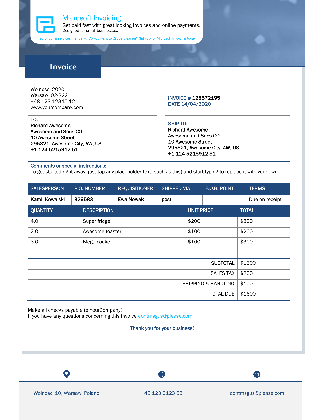
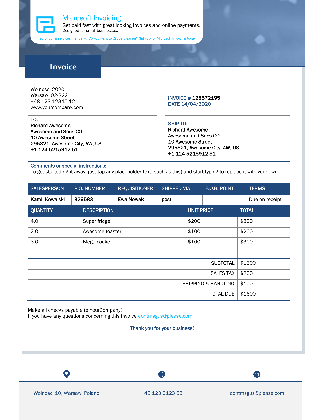
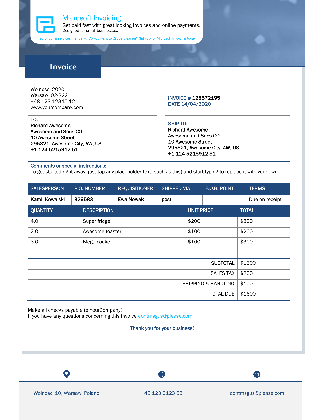
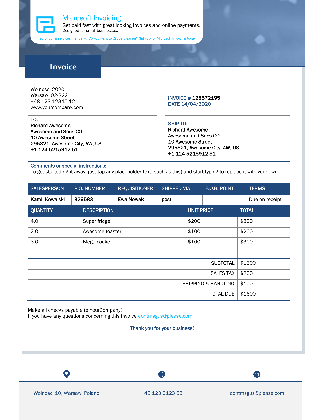
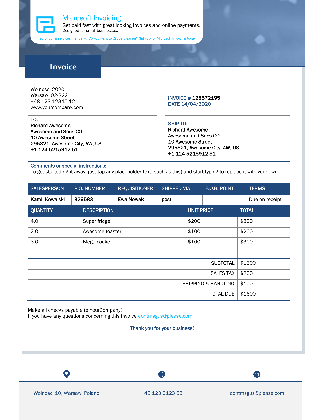
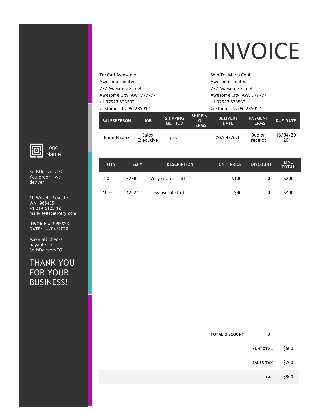
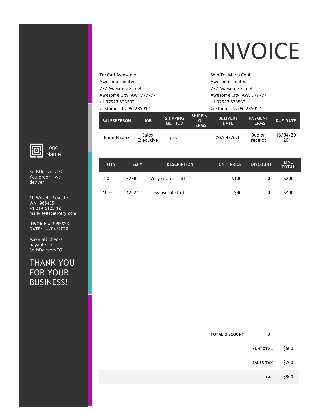
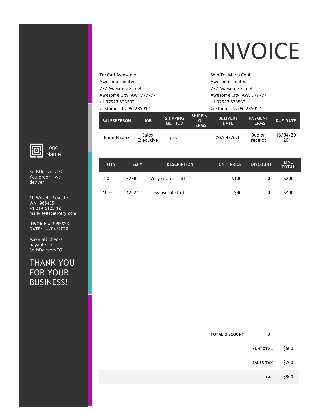
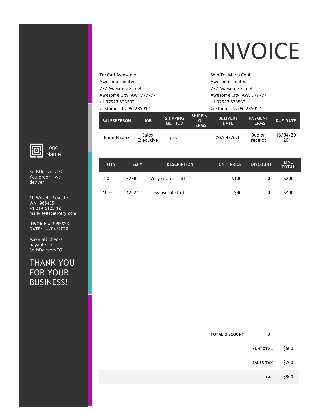
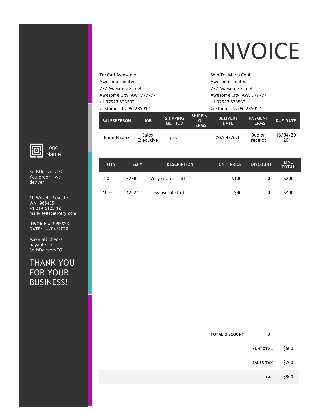
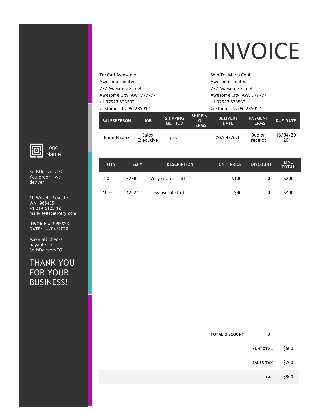
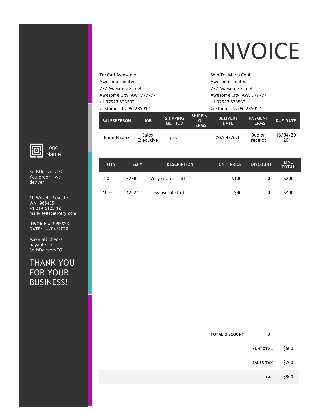
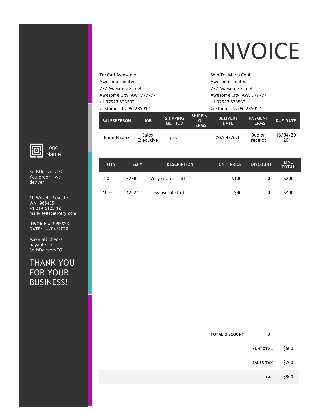
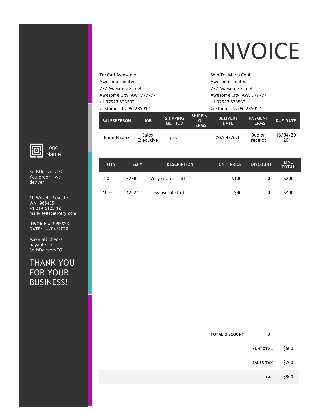
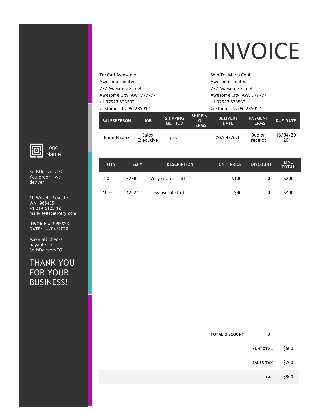

In [15]:
ipyplot.plot_class_tabs(
    images=IMG_PATHS, 
    labels=labels,
    max_imgs_per_tab=10,
    img_width=210,
    force_b64=True
)

#### Print first element from each cluster 


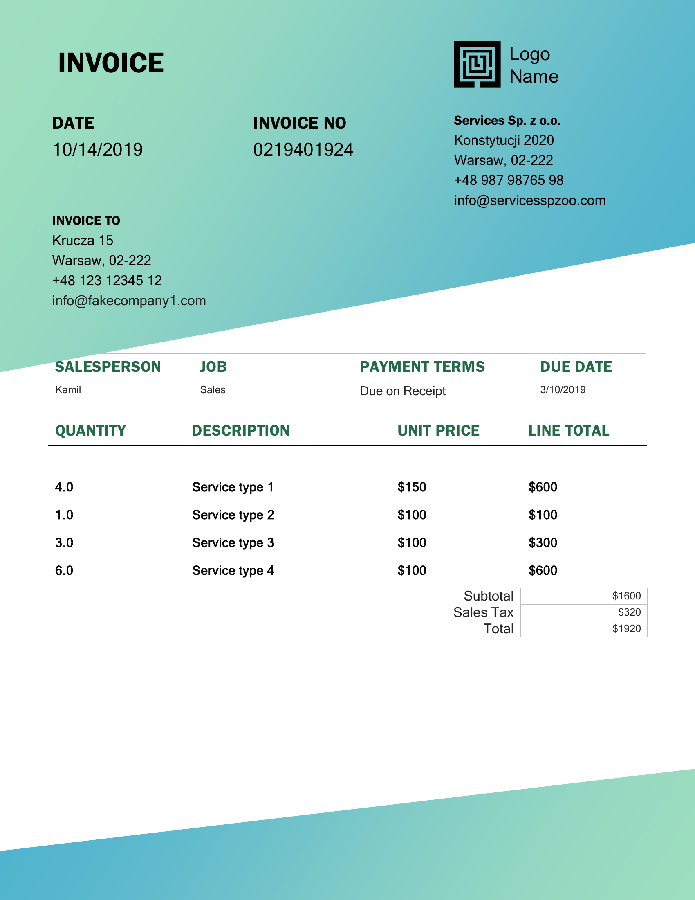
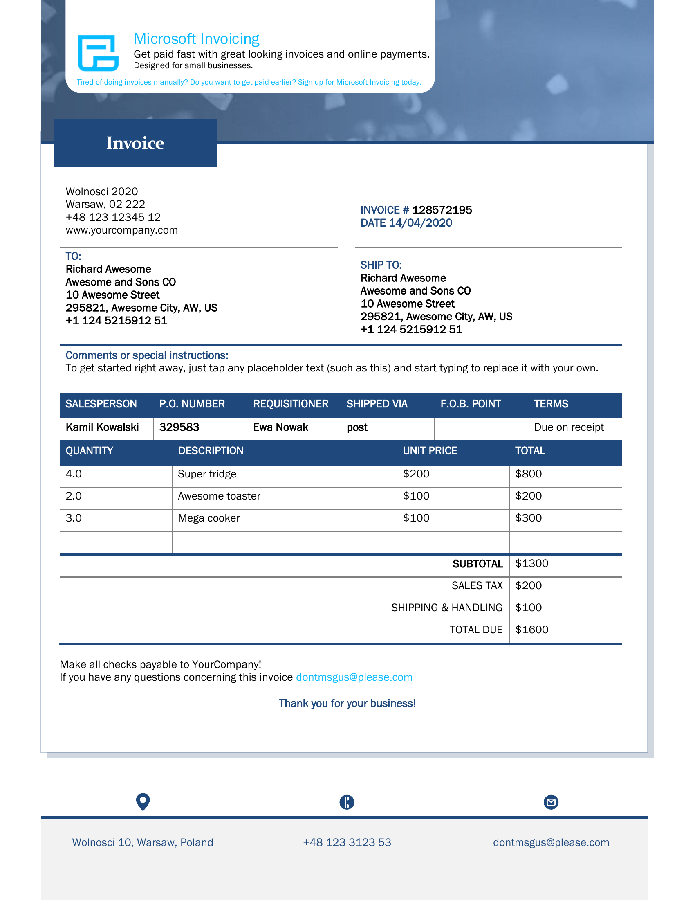
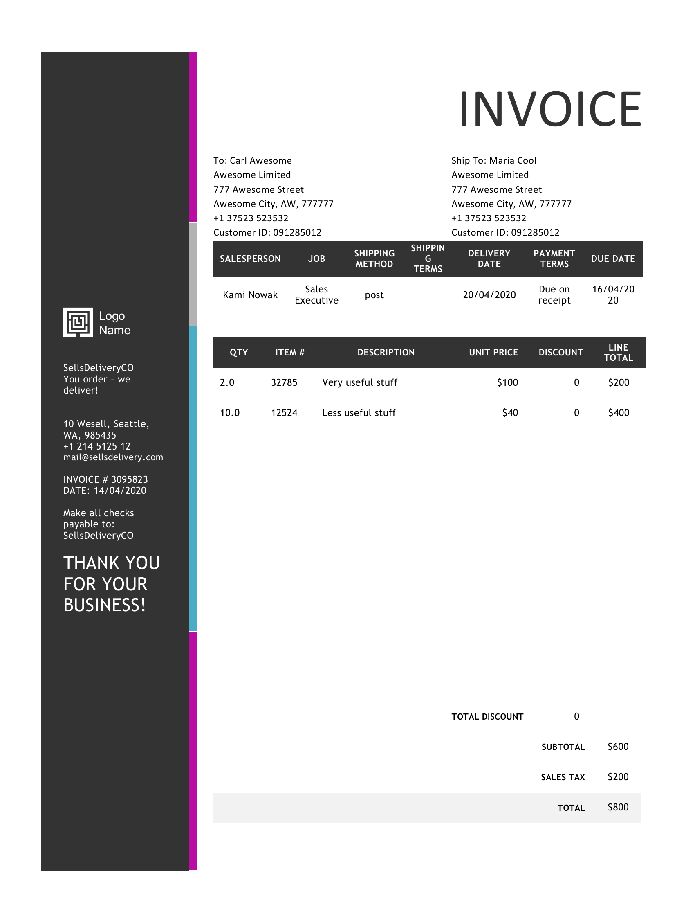

In [16]:
# takes in labels from clustering and coresponding IMG_PATHS
ipyplot.plot_class_representations(
    images=IMG_PATHS, 
    labels=labels, 
    img_width=450, 
    force_b64=True
)

#### Print top N samples for specific cluster


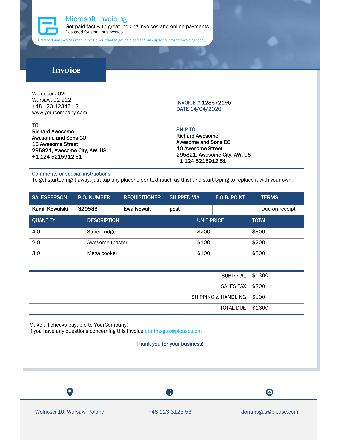
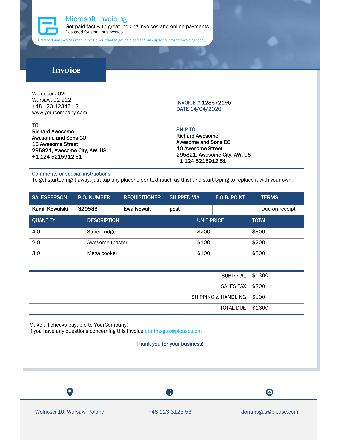
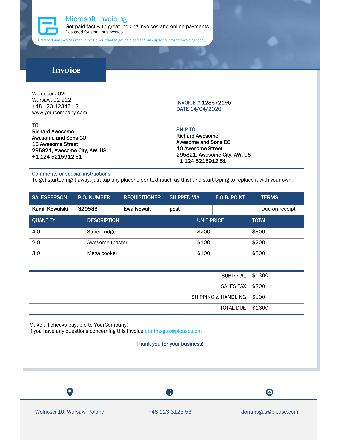
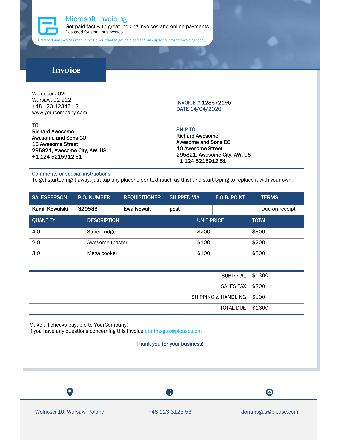
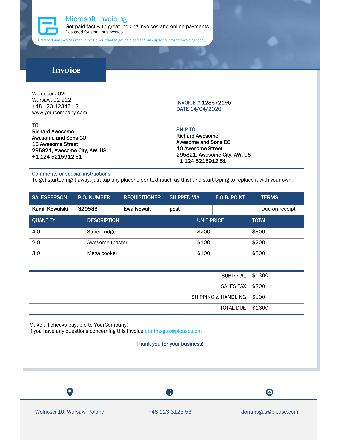

In [17]:
ipyplot.plot_images(
    images=IMG_PATHS[labels=='01'],
    max_images=5,
    img_width=220,
    force_b64=True
)

### 4.4 Saving results
[back to the top](#Navigation:)

In [18]:
# asign detected cluster labels to LayoutType field
df_example['LayoutType'] = labels
# rename cluster names from numbers to some actual string names
df_example['LayoutType'] = df_example['LayoutType'].apply(lambda x: x if (x == '-1') else 'layout_type_' + x)
# 
df_example.reset_index()[['ImageName', 'FileName', 'LayoutType']].to_csv(
    os.path.join(DATASET_DIR, 'df_example_pred.csv'), index=False)

## 5. Using your own data
[back to the top](#Navigation:)

To use this notebook with your own data you should have all your data located under a single directory and start from [Setup step](#1.-Setup) and just follow the tutorial step by step ignoring point `1.3` as it is related to our sample fabricated dataset.